# 1. Import libraries

In [27]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import re
import seaborn as sns
import matplotlib.pyplot as plt
import gc
import os
from transformers import AutoTokenizer, AutoModelForTokenClassification
from nltk.probability import FreqDist
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from datasets import Dataset
from sklearn.preprocessing import OneHotEncoder
from  sklearn.preprocessing import OrdinalEncoder
from tqdm import tqdm
from torch.autograd import Variable
from datasets import load_dataset
from pathlib import Path
from torchmetrics.classification import FBetaScore, Accuracy, MulticlassPrecision, MulticlassRecall
from torchmetrics.classification import BinaryFBetaScore, BinaryAccuracy, BinaryPrecision, BinaryRecall
from transformers import Trainer, TrainingArguments

# 2. Setting parameters for learning and loading data

In [2]:
MODEL_PATH = "lakshyakh93/deberta_finetuned_pii"
MAX_LENGTH = 512
CONF_THRESH = 0.9
LR = 2.5e-5
LR_SCHEDULER_TYPE = "linear"
NUM_EPOCHS = 5
BATCH_SIZE = 1
EVAL_BATCH_SIZE = 8
GRAD_ACCUMULATION_STEPS = 16 // BATCH_SIZE
WARMUP_RATIO = 0.1
WEIGHT_DECAY = 0.01
AMP = True
FREEZE_EMBEDDING = False
FREEZE_LAYERS = 6
OUTPUT_DIR = "output"
Path(OUTPUT_DIR).mkdir(exist_ok=True)

In [ ]:
!unzip ./data-20240604T160432Z-001.zip

In [5]:
# Original data
data_df = pd.read_json('./data-20240604T160432Z-001/data/train.json')
test_df = pd.read_json('./data-20240604T160432Z-001/data/test.json')

# External data
ai_4data = load_dataset("ai4privacy/pii-masking-200k", data_files=['english_pii_43k.jsonl']) # use "language" column
pii_ext_data = pd.read_csv('./data-20240604T160432Z-001/data/pii_dataset.csv')
pii_mixtral = pd.read_json('./data-20240604T160432Z-001/data/mpware_mixtral8x7b_v1.1-no-i-username.json')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/ai4privacy--pii-masking-200k-84f60b628c61cc70/0.0.0/ac0ca5f5289a6cf108e706efcf040422dbbfa8e658dee6a819f20d76bb84d26b. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
set_prefix = lambda x: ('B-' + x, 'I-' + x)

ai4_labels = ['EMAIL', 'FIRSTNAME', 'LASTNAME', 'URL', 'PHONENUMBER', 'USERNAME']
correct_labels = ['EMAIL', 'NAME_STUDENT', 'NAME_STUDENT', 'URL_PERSONAL', 'PHONE_NUM', 'USERNAME']

ai4_label_mapping = set([(k, v) for l1, l2 in zip(ai4_labels, correct_labels) for k, v in zip(set_prefix(l1), set_prefix(l2))])
ai4_label_mapping = dict(ai4_label_mapping)
ai4_label_mapping['B-LASTNAME'] = 'I-NAME_STUDENT'

ai4_labels_to_exclude = ['CITY', 'STATE', 'STREET', 
                         #'URL', ,
                        #'FIRSTNAME',
                        #'LASTNAME',
                        ]

def is_correct(data):
    #print(data)
    for label in data:
        if label in ai4_labels_to_exclude:
            return False
    return True

def preprocess_texts(data):
    #print(data)
    new_labels = []
    for label in data['mbert_bio_labels']:
        if ai4_label_mapping.get(label):
            new_labels.append(ai4_label_mapping[label])
        else:
            new_labels.append('O')
            
    data['bio_labels'] = new_labels     
    return data

ai4_1 = ai_4data.filter(is_correct, input_columns=['mbert_bio_labels'])
ai4_2 = ai4_1.map(preprocess_texts)
ai4_2 = ai4_2.filter(lambda x: any([label != 'O' for label in x['bio_labels']]))

pii_ext_data['labels_2'] = pii_ext_data['labels'].apply(lambda x: re.subn(r'[\[\]\'\']', '', x)[0].split(', '))
pii_ext_data['tokens_2'] = pii_ext_data['tokens'].apply(lambda x: re.subn(r'[\[\]\'\']', '', x)[0].split(', '))

  0%|          | 0/44 [00:00<?, ?ba/s]

  0%|          | 0/43501 [00:00<?, ?ex/s]

  0%|          | 0/44 [00:00<?, ?ba/s]

In [20]:
# Concatenate all together
df1 = ai4_2['train'].to_pandas()
df1 = df1[['source_text', 'mbert_text_tokens', 'bio_labels']]
df1 = df1.rename(columns={'source_text': 'full_text', 'mbert_text_tokens': 'tokens', 'bio_labels': 'labels'})

df2 = data_df[['full_text', 'tokens', 'labels']]
#df_2 = Dataset.from_pandas(df2).train_test_split(test_size=0.7)
#df_2, eval_data = df_2['train'].to_pandas(), df_2['test'] #evaluation on original data

df3 = pii_ext_data[['text', 'tokens_2', 'labels_2']]
df3 = df3.rename(columns={'text': 'full_text', 'labels_2': 'labels', 'tokens_2': 'tokens'})

df4 = pii_mixtral[['full_text', 'tokens', 'labels']]

#eval_data = eval_data.map(lambda x: {'labels': [label2id[i] for i in x['labels']]})
#eval_data = eval_data.map(lambda x: {'labels': ore.transform([[i] for i in x['labels']]).reshape(-1)})
train_df = pd.concat([df2, df1, df3, df4], ignore_index=True, sort=False)

In [14]:
def visualize_labels_distribution(labels):
    all_labels = pd.DataFrame([l for labels in labels.to_list() for l in labels], columns=['labels'])

    ax = sns.countplot(all_labels, x='labels', width=0.2, palette='Set2')
    ax.tick_params(axis='x', rotation=90)
    for label in ax.containers:
        ax.bar_label(label)
    plt.yscale('log')

In [ ]:
# before external data
#visualize_labels_distribution(data_df['labels'])

In [ ]:
# after external data
#visualize_labels_distribution(train_df['labels'])

In [21]:
uniq_labels = set([l for labels in train_df['labels'].to_list() for l in labels])

train_df_1 = train_df.copy()

ore = OrdinalEncoder(dtype='int')
ore.fit([[label] for label in uniq_labels])
OUT_LABEL = ore.transform([['O']])[0][0]
#train_df_1['labels'] = train_df_1['labels'].apply(lambda x: [label2id[i] for i in x])
train_df_1['labels'] = train_df_1['labels'].apply(lambda x: ore.transform([[i] for i in x]).reshape(-1))


data_test = Dataset.from_pandas(test_df[['document','full_text', 'tokens']])
data_all = Dataset.from_pandas(train_df_1)
#data_all = data_all.train_test_split(test_size=0.2)

In [16]:
# Loading Model
id2label = {str(ore.transform([[l]])[0][0]): l for l in uniq_labels}
label2id = {v: k for k, v in id2label.items()}

tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model = AutoModelForTokenClassification.from_pretrained(MODEL_PATH,
                                                        id2label=id2label,
                                                        label2id=label2id,
                                                        ignore_mismatched_sizes=True)

# 3. Tokenization and transformations of input data

In [17]:
def extend_labels(data):
    new_labels = []
    
    #for i in data['overflow_to_sample_mapping']:
    for i in range(len(data['input_ids'])):
        # making num labels correspond num tokens
        new_label = np.array(data['labels'][i])[[el for el in data['word_ids'][i] if el != None]]
        #new_labels = np.array(data['labels'])[data['word_ids']]
        
        if len(new_label) < MAX_LENGTH:
            n = (MAX_LENGTH - len(new_label)) - 1
            new_label = np.concatenate(([-100], new_label, np.array([-100] * n)))
        new_labels.append(new_label)
        
    data['labels'] = np.array(new_labels)
    return data

In [18]:
def tokenize_texts(texts):
    res = tokenizer(texts['tokens'],
                    is_split_into_words=True, 
                    max_length=MAX_LENGTH, 
                    truncation=True,
                    padding='max_length',
                    return_overflowing_tokens=True,
                    add_special_tokens = True,
                    return_token_type_ids=True)
    if texts.get('labels'):
        res['labels'] = [texts['labels'][i] for i in res['overflow_to_sample_mapping']]
    else:
        res['document'] = [texts['document'][i] for i in res['overflow_to_sample_mapping']]
    
    res['word_ids'] = [res.word_ids(i) for i in range(len(res['input_ids']))]
    return res

In [22]:
data_all_1 = data_all.map(tokenize_texts, batched=True, remove_columns=['tokens', 'full_text'], num_proc=os.cpu_count())
data_all_2 = data_all_1.map(extend_labels, batched=True, remove_columns=['word_ids'], num_proc=os.cpu_count())

data_test_1 = data_test.map(tokenize_texts, batched=True, remove_columns=['full_text', 'tokens'], num_proc=os.cpu_count())

data_all_2.set_transform(lambda x: {k: torch.tensor(v) for k, v in x.items()})

#0:   0%|          | 0/9 [00:00<?, ?ba/s]

#1:   0%|          | 0/9 [00:00<?, ?ba/s]

#2:   0%|          | 0/9 [00:00<?, ?ba/s]

#3:   0%|          | 0/9 [00:00<?, ?ba/s]

#0:   0%|          | 0/12 [00:00<?, ?ba/s]

#1:   0%|          | 0/12 [00:00<?, ?ba/s]

#2:   0%|          | 0/12 [00:00<?, ?ba/s]

#3:   0%|          | 0/12 [00:00<?, ?ba/s]

#0:   0%|          | 0/1 [00:00<?, ?ba/s]

#2:   0%|          | 0/1 [00:00<?, ?ba/s]

#1:   0%|          | 0/1 [00:00<?, ?ba/s]

#3:   0%|          | 0/1 [00:00<?, ?ba/s]

# 4. Defining model's trainable parameters,e metrics and train the model through Trainer

In [23]:
def regulize_bert_params(model, freeze_layers=6, freeze_embedding=False):
    for param in model.deberta.embeddings.parameters():
            param.requires_grad = False if freeze_embedding else True

    for layer in model.deberta.encoder.layer[:freeze_layers]:
        for param in layer.parameters():
            param.requires_grad = False

    return model
    
model = regulize_bert_params(model, freeze_layers=0, freeze_embedding=False)

In [24]:
device = 'cuda' if torch.has_cuda else 'cpu'

model.to(device)

DebertaForTokenClassification(
  (deberta): DebertaModel(
    (embeddings): DebertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=0)
      (LayerNorm): DebertaLayerNorm()
      (dropout): StableDropout()
    )
    (encoder): DebertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaLayer(
          (attention): DebertaAttention(
            (self): DisentangledSelfAttention(
              (in_proj): Linear(in_features=768, out_features=2304, bias=False)
              (pos_dropout): StableDropout()
              (pos_proj): Linear(in_features=768, out_features=768, bias=False)
              (pos_q_proj): Linear(in_features=768, out_features=768, bias=True)
              (dropout): StableDropout()
            )
            (output): DebertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): DebertaLayerNorm()
              (dropout): StableDropout()
            )
          )
          (int

In [25]:
metrics = {'F1': FBetaScore('multiclass', num_classes=len(uniq_labels), ignore_index=-100, beta=5., average='macro'),
          'Accuracy': Accuracy('multiclass', num_classes=len(uniq_labels), ignore_index=-100, average='macro'),
          'Precision': MulticlassPrecision(num_classes=len(uniq_labels), ignore_index=-100, average='macro'),
          'Recall': MulticlassRecall(num_classes=len(uniq_labels), ignore_index=-100, average='macro')
          }

def compute_metrics(eval_preds):
    preds = torch.softmax(torch.tensor(eval_preds.predictions), dim=-1)
    targets = torch.tensor(eval_preds.label_ids)

    res = {}

    for name, met in metrics.items():
        res[name] = met(preds.transpose(1, 2), targets)

    return res

In [28]:
args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    fp16=AMP,
    learning_rate=LR,
    num_train_epochs=NUM_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=EVAL_BATCH_SIZE,
    gradient_accumulation_steps=GRAD_ACCUMULATION_STEPS,
    report_to="none",
    #evaluation_strategy="steps",
    #eval_steps=250,
    #eval_delay=500,
    save_strategy="steps",
    save_steps=500,
    save_total_limit=4,
    logging_steps=500,
    metric_for_best_model="F1",
    greater_is_better=True,
    #load_best_model_at_end=True,
    overwrite_output_dir=True,
    lr_scheduler_type=LR_SCHEDULER_TYPE,
    warmup_ratio=WARMUP_RATIO,
    weight_decay=WEIGHT_DECAY,
)

In [30]:
trainer = Trainer(
        args=args,
        model=model,
        train_dataset=data_all_2,
        #eval_dataset=eval_data_1,
        tokenizer=tokenizer,
        #compute_metrics=compute_metrics,
    )

#trainer.train()

In [ ]:
gc.collect()
torch.cuda.empty_cache()

## Using already pretrained model for predictions

In [39]:
# pretrained model https://www.kaggle.com/models/diacious/deberta_ner

#tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
#model = AutoModelForTokenClassification.from_pretrained(MODEL_PATH)
#model.to(device)

#id2label = {int(k): v for k, v in model.config.id2label.items()}
#label2id = {v: k for k, v in id2label.items()}

In [36]:
uniq_labels = set([l for labels in train_df['labels'].to_list() for l in labels])

train_df_1 = train_df.copy()

train_df_1['labels'] = train_df_1['labels'].apply(lambda x: [label2id[i] for i in x])

data_test = Dataset.from_pandas(test_df[['document', 'full_text', 'tokens']])
data_all = Dataset.from_pandas(train_df_1)

data_all_1 = data_all.map(tokenize_texts, batched=True, remove_columns=['tokens', 'full_text'], num_proc=os.cpu_count())
data_all_2 = data_all_1.map(extend_labels, batched=True, remove_columns=['word_ids'], num_proc=os.cpu_count())

data_test_1 = data_test.map(tokenize_texts, batched=True, remove_columns=['full_text', 'tokens'], num_proc=os.cpu_count())

data_all_2.set_transform(lambda x: {k: torch.tensor(v) for k, v in x.items()})

#0:   0%|          | 0/9 [00:00<?, ?ba/s]

#1:   0%|          | 0/9 [00:00<?, ?ba/s]

#2:   0%|          | 0/9 [00:00<?, ?ba/s]

#3:   0%|          | 0/9 [00:00<?, ?ba/s]

#0:   0%|          | 0/12 [00:00<?, ?ba/s]

#1:   0%|          | 0/12 [00:00<?, ?ba/s]

#2:   0%|          | 0/12 [00:00<?, ?ba/s]

#3:   0%|          | 0/12 [00:00<?, ?ba/s]

#0:   0%|          | 0/1 [00:00<?, ?ba/s]

#1:   0%|          | 0/1 [00:00<?, ?ba/s]

#2:   0%|          | 0/1 [00:00<?, ?ba/s]

#3:   0%|          | 0/1 [00:00<?, ?ba/s]

In [37]:
def get_predicted_labels(batch):
    #with torch.no_grad():
    with torch.no_grad():
        input_ids, token_type_ids, attention_mask = [el.to(device) for el in batch]
        #test_preds = bert_ner(**test_data)
        test_preds  = model(input_ids, attention_mask)
        test_preds_probs = torch.softmax(test_preds.logits, dim=2)
        test_preds_labels = test_preds_probs.argmax(dim=2) # (btsz, tokens)
        
    return test_preds_labels


def get_prediction(data):
    pred_labels = {'document': [],
                    'token': [],
                    'label': []}
   
    keys = ['input_ids', 'token_type_ids', 'attention_mask']
    batch = [torch.tensor(data[k]) for k in keys]
    preds = get_predicted_labels(batch)
    
    return {'preds': preds.tolist()}


def get_tokens_label(data):
    pred_labels = {'document': [],
                    'token': [],
                    'label': []}
   
    preds = data['preds']
    
    for i, doc_id in enumerate(data['document']):
            pred_tok_labels = {}
            
            for j, tok in enumerate(data['word_ids'][i]):
                if tok != None:
                    label = id2label[preds[i][j]]
                    if pred_tok_labels.get(tok):       
                        if  pred_tok_labels[tok].get(label):
                            pred_tok_labels[tok][label] += 1
                        else:
                            pred_tok_labels[tok][label] = 1
                    else:
                        pred_tok_labels[tok] = {label: 1}
                        
            pred_tok_labels = {k: max(v.items(), key=lambda x: x[-1])[0] for k,v  in pred_tok_labels.items()}
            pred_tok_labels = {k: v for k, v in pred_tok_labels.items() if v != 'O'}
            
            pred_labels['document'].extend([doc_id] * len(pred_tok_labels))
            pred_labels['token'].extend(list(pred_tok_labels.keys()))
            pred_labels['label'].extend(list(pred_tok_labels.values()))
        
    return pred_labels

In [40]:
submission = data_test_1.map(get_prediction, batched=True, batch_size=16, remove_columns=['input_ids', 'token_type_ids', 'attention_mask', 'overflow_to_sample_mapping'])
submission = submission.map(get_tokens_label, batched=True, batch_size=16, remove_columns=['word_ids', 'preds'])
submission = submission.to_pandas()
if not len(submission):
    submission = pd.DataFrame([[data_test_1['document'][0], 0, 'B-EMAIL']], columns=['document', 'token', 'label'])
submission = submission.drop_duplicates()
submission.to_csv('./submission.csv', index_label='row_id')

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

# Results from submissions
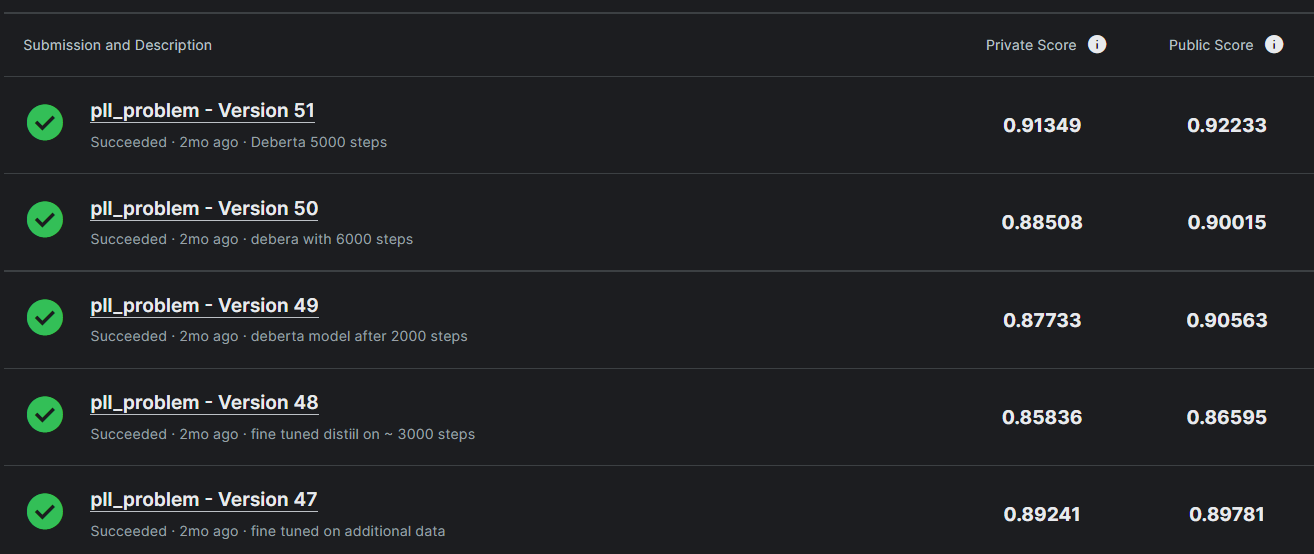